# JOB SECTOR CLASSIFICATION

### PACKAGES

In [2]:
# !pip install tensorflow

In [3]:
# !pip install PyPDF2

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\intel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\intel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\intel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\intel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords

import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import f1_score,recall_score,precision_score

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
import pickle
# import PyPDF2

### DATASET

In [3]:
df = pd.read_csv('job_scrap_dataset.csv')

#### PREVIEW OF THE DATA

In [4]:
df.head()

,Unnamed: 0,industry,job_designation,job_description,responsibilities,requirements_skills,url_links
0,0,Accounting,Billing Manager job description,We are looking for a Billing Manager to join o...,Oversee the preparation of statements and bill...,Proven work experience as a Billing Manager or...,https://resources.workable.com/billing-manager...
1,1,Accounting,Accounts Payable Specialist job description,We are looking for an Accounts Payable Special...,Charge expenses to accounts and cost centers a...,Proven work experience as an Accounts Payable ...,https://resources.workable.com/accounts-payabl...
2,2,Accounting,Medical Biller job description,We are looking for a Medical Biller to join ou...,Generate revenue by making payment arrangement...,Proven work experience as a Medical Biller or ...,https://resources.workable.com/medical-biller-...
3,3,Accounting,Cost analyst job description,We are looking for a cost analyst to help us a...,Gather and analyze financial data\nDetermine s...,"Proven experience as a cost analyst, cost spec...",https://resources.workable.com/cost-analyst-jo...
4,4,Accounting,Payroll Accountant job description,We are looking for an experienced payroll acco...,Oversee employee paychecks\nCalculate net sala...,Previous experience as a payroll accountant or...,https://resources.workable.com/payroll-account...


#### DIMENSION OF THE DATA

In [5]:
df.shape

(1029, 7)

#### DATASET DESCRIPTION

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1029 non-null   int64 
 1   industry             1029 non-null   object
 2   job_designation      1029 non-null   object
 3   job_description      1029 non-null   object
 4   responsibilities     1029 non-null   object
 5   requirements_skills  1029 non-null   object
 6   url_links            1029 non-null   object
dtypes: int64(1), object(6)
memory usage: 56.4+ KB


### EXPLORATORY DATA ANALYSIS & TEXT PREPROCESSING

#### CHECKING MISSING VALUES

In [7]:
df.isnull().sum()

Unnamed: 0             0
industry               0
job_designation        0
job_description        0
responsibilities       0
requirements_skills    0
url_links              0
dtype: int64

#### UNIQUE VALUES DATA

In [8]:
pd.DataFrame(df.industry.unique()).values

array([['Accounting'],
       ['Finance'],
       ['Administrative'],
       ['IT and Development'],
       ['Design'],
       ['Customer service'],
       ['Educator & Education'],
       ['Corporate training'],
       ['Engineering'],
       ['Construction'],
       ['Production'],
       ['Healthcare'],
       ['Pharmaceuticals'],
       ['Hospitality'],
       ['Travel & Tourism'],
       ['Human Resources (HR)'],
       ['Law enforcement / Security'],
       ['Legal'],
       ['Logistics'],
       ['Facilities'],
       ['Marketing'],
       ['Public Relations (PR)'],
       ['Media'],
       ['Real estate'],
       ['Sales'],
       ['Retail']], dtype=object)

There are 25 different classes or categories (target). 

#### TEXT PRE-PROCESSING

In [9]:
stop_words = set(stopwords.words('english'))

def clean(Text):
    Text = re.sub('\r\n', ' ', Text) # remove blank spaces
    Text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-/:;<=>?@[\]^_`{|}~"""), ' ', Text)  # remove punctuations
    Text = re.sub(r'[^\x00-\x7f]',r' ', Text) # non ascii values
    Text = re.sub('\s+', ' ', Text)  # remove extra whitespace
    
    Text = Text.replace('job description','')
    Text = Text.lower() # convert to lower case
    tokens = nltk.word_tokenize(Text) # tokenize
    filtered_text = [word for word in tokens if not word in stop_words] # remove stop words
    return ' '.join(filtered_text)


In [10]:
# COMBINING THE REQUIRED DATASET INTO A SINGLE COLUMN

df["resume"] = df[['industry', 'job_designation','job_description','responsibilities', 'requirements_skills']].astype(object).apply(" ".join, axis=1)

In [11]:
df['processed_data'] = df['resume'].apply(lambda x:clean(x))
df.head()

,Unnamed: 0,industry,job_designation,job_description,responsibilities,requirements_skills,url_links,resume,processed_data
0,0,Accounting,Billing Manager job description,We are looking for a Billing Manager to join o...,Oversee the preparation of statements and bill...,Proven work experience as a Billing Manager or...,https://resources.workable.com/billing-manager...,Accounting Billing Manager job description We ...,accounting billing manager looking billing man...
1,1,Accounting,Accounts Payable Specialist job description,We are looking for an Accounts Payable Special...,Charge expenses to accounts and cost centers a...,Proven work experience as an Accounts Payable ...,https://resources.workable.com/accounts-payabl...,Accounting Accounts Payable Specialist job des...,accounting accounts payable specialist looking...
2,2,Accounting,Medical Biller job description,We are looking for a Medical Biller to join ou...,Generate revenue by making payment arrangement...,Proven work experience as a Medical Biller or ...,https://resources.workable.com/medical-biller-...,Accounting Medical Biller job description We a...,accounting medical biller looking medical bill...
3,3,Accounting,Cost analyst job description,We are looking for a cost analyst to help us a...,Gather and analyze financial data\nDetermine s...,"Proven experience as a cost analyst, cost spec...",https://resources.workable.com/cost-analyst-jo...,Accounting Cost analyst job description We are...,accounting cost analyst looking cost analyst h...
4,4,Accounting,Payroll Accountant job description,We are looking for an experienced payroll acco...,Oversee employee paychecks\nCalculate net sala...,Previous experience as a payroll accountant or...,https://resources.workable.com/payroll-account...,Accounting Payroll Accountant job description ...,accounting payroll accountant looking experien...


#### DROP OF UNWANTED COLUMNS

In [12]:
df.drop('Unnamed: 0', inplace=True, axis=1)

#### ENCODING FEATURES

In [13]:
label = LabelEncoder()
df['target'] = label.fit_transform(df['industry'])

#### AFTER PREPROCESSING DATASET PREVIEW

In [14]:
df.head()

,industry,job_designation,job_description,responsibilities,requirements_skills,url_links,resume,processed_data,target
0,Accounting,Billing Manager job description,We are looking for a Billing Manager to join o...,Oversee the preparation of statements and bill...,Proven work experience as a Billing Manager or...,https://resources.workable.com/billing-manager...,Accounting Billing Manager job description We ...,accounting billing manager looking billing man...,0
1,Accounting,Accounts Payable Specialist job description,We are looking for an Accounts Payable Special...,Charge expenses to accounts and cost centers a...,Proven work experience as an Accounts Payable ...,https://resources.workable.com/accounts-payabl...,Accounting Accounts Payable Specialist job des...,accounting accounts payable specialist looking...,0
2,Accounting,Medical Biller job description,We are looking for a Medical Biller to join ou...,Generate revenue by making payment arrangement...,Proven work experience as a Medical Biller or ...,https://resources.workable.com/medical-biller-...,Accounting Medical Biller job description We a...,accounting medical biller looking medical bill...,0
3,Accounting,Cost analyst job description,We are looking for a cost analyst to help us a...,Gather and analyze financial data\nDetermine s...,"Proven experience as a cost analyst, cost spec...",https://resources.workable.com/cost-analyst-jo...,Accounting Cost analyst job description We are...,accounting cost analyst looking cost analyst h...,0
4,Accounting,Payroll Accountant job description,We are looking for an experienced payroll acco...,Oversee employee paychecks\nCalculate net sala...,Previous experience as a payroll accountant or...,https://resources.workable.com/payroll-account...,Accounting Payroll Accountant job description ...,accounting payroll accountant looking experien...,0


#### VISUALIZING MISSING VALUES

<Axes: >

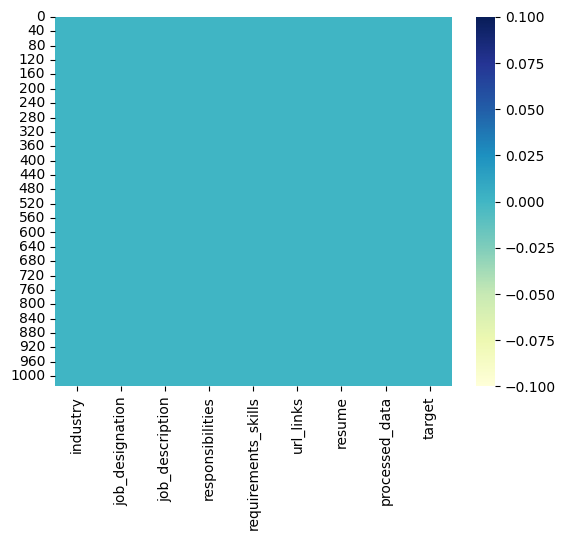

In [15]:
sns.heatmap(data = df.isna(),cmap="YlGnBu")

#### VISUALIZNG THE DATA

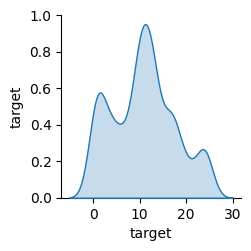

In [16]:
sns.pairplot(df,diag_kind='kde',kind='reg')

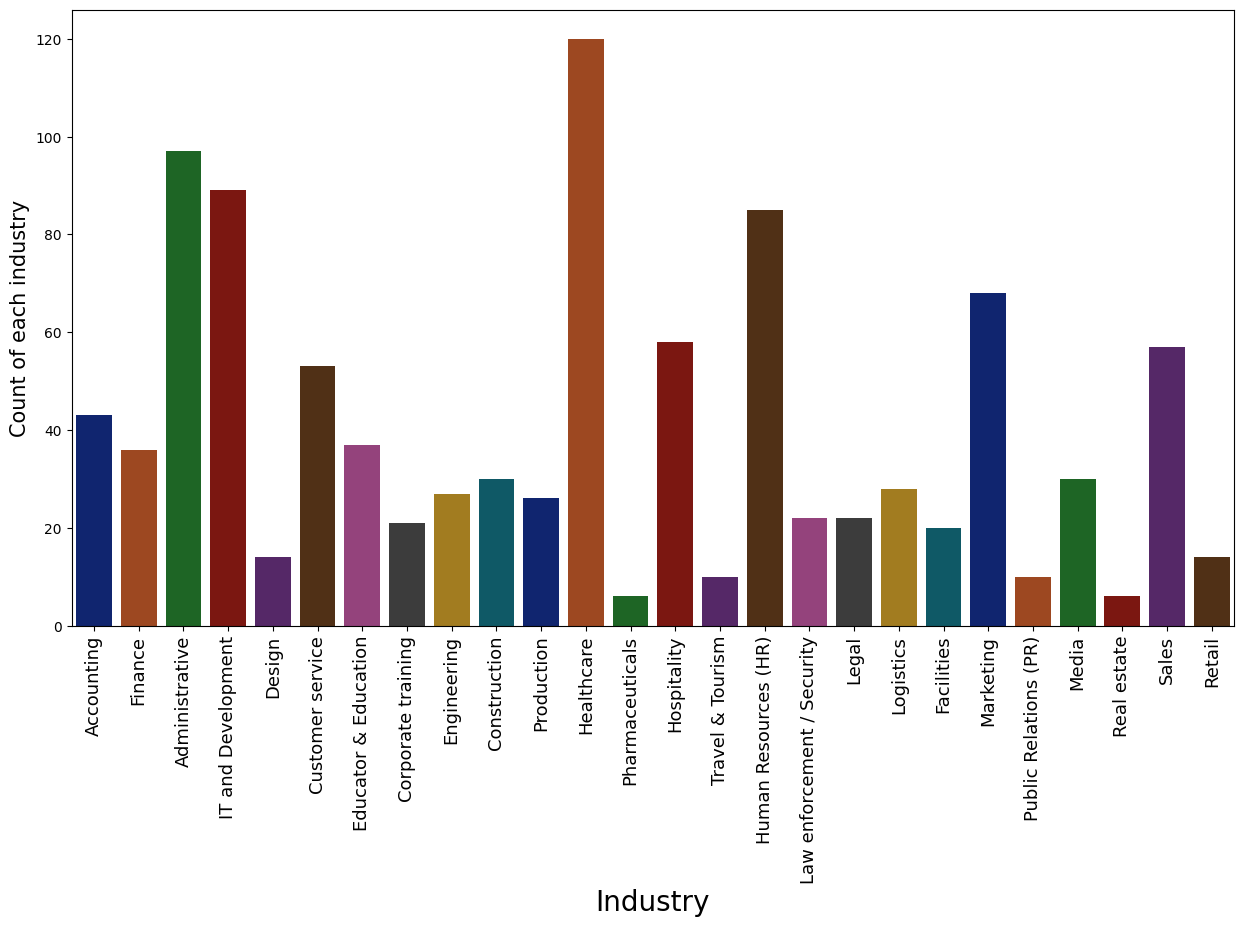

In [17]:
plt.figure(figsize=(15,8))
countplot = sns.countplot(x='industry', palette='dark',data=df)
plt.ylabel("Count of each industry", size = 15)
plt.xlabel("Industry", size = 20)
countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90, size = 13)
plt.show()

In [18]:
category = df['industry'].value_counts().reset_index()
category

,industry,count
0,Healthcare,120
1,Administrative,97
2,IT and Development,89
3,Human Resources (HR),85
4,Marketing,68
5,Hospitality,58
6,Sales,57
7,Customer service,53
8,Accounting,43
9,Educator & Education,37


#### VISUALIZING THE FREQUENCY PLOT OF TARGET DATA

In [19]:
df['target'].unique()

array([ 0,  9,  1, 13,  5,  4,  6,  3,  7,  2, 20, 10, 19, 11, 25, 12, 14,
       15, 16,  8, 17, 21, 18, 22, 24, 23])

(array([170.,  74.,  78.,  56., 263., 111., 118.,  36.,  42.,  81.]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]),
 <BarContainer object of 10 artists>)

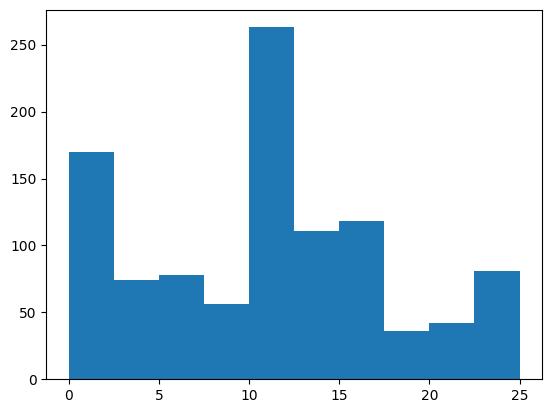

In [20]:
plt.hist(df['target'])

<Axes: xlabel='target', ylabel='Density'>

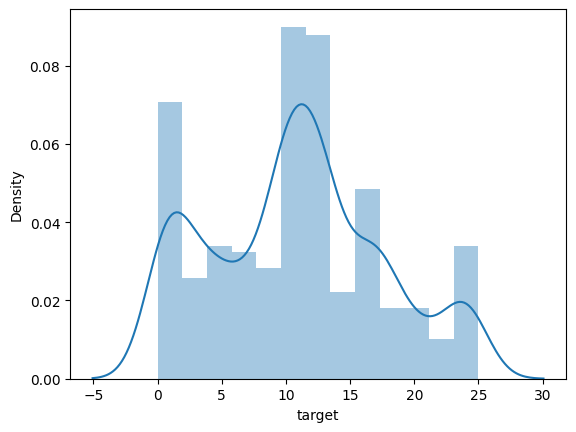

In [21]:
sns.distplot(df.target)

### DATA PREPARATION FOR MODEL BUILDING

#### VECTORIZATION THE DATA

In [22]:
vectorizer = TfidfVectorizer()

#### DEFINING INDEPENDENT AND DEPENDENT VARIABLES

In [23]:
text = vectorizer.fit_transform(df.processed_data).toarray()

In [24]:
target = df['target']

In [25]:
with open('vectorizer_model.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

#### SPLIT DATA INTO TRAIN AND TEST

In [26]:
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size = 0.20, random_state = 0)

In [27]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(823, 7792) (206, 7792) (823,) (206,)


### MODEL EVALUATION

In [28]:
def eval_sc(clf, X_train, X_test, y_train, y_test):
    
    # Model Fitting
    model = clf.fit(X_train, y_train)
    
    # Prediction
    y_pred = model.predict(X_test)
    
    # Accuracy
    acc = metrics.accuracy_score(y_test,y_pred)
    print("\nAccuracy : ",acc,"%")

    # Confusion Matrix
    print("\nConfusion Matrix :")
    plt.figure(figsize = (12,12))
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='g')
    plt.show()
    
    print("\nClassification Report :")
    cm = metrics.classification_report(y_test, y_pred)
    print("\n",cm)
    
    return acc



### MODEL IMPLEMENTATION

#### NAIVE BAYES CLASSIFIER

In [29]:
NB = MultinomialNB()


Accuracy :  0.5194174757281553 %

Confusion Matrix :


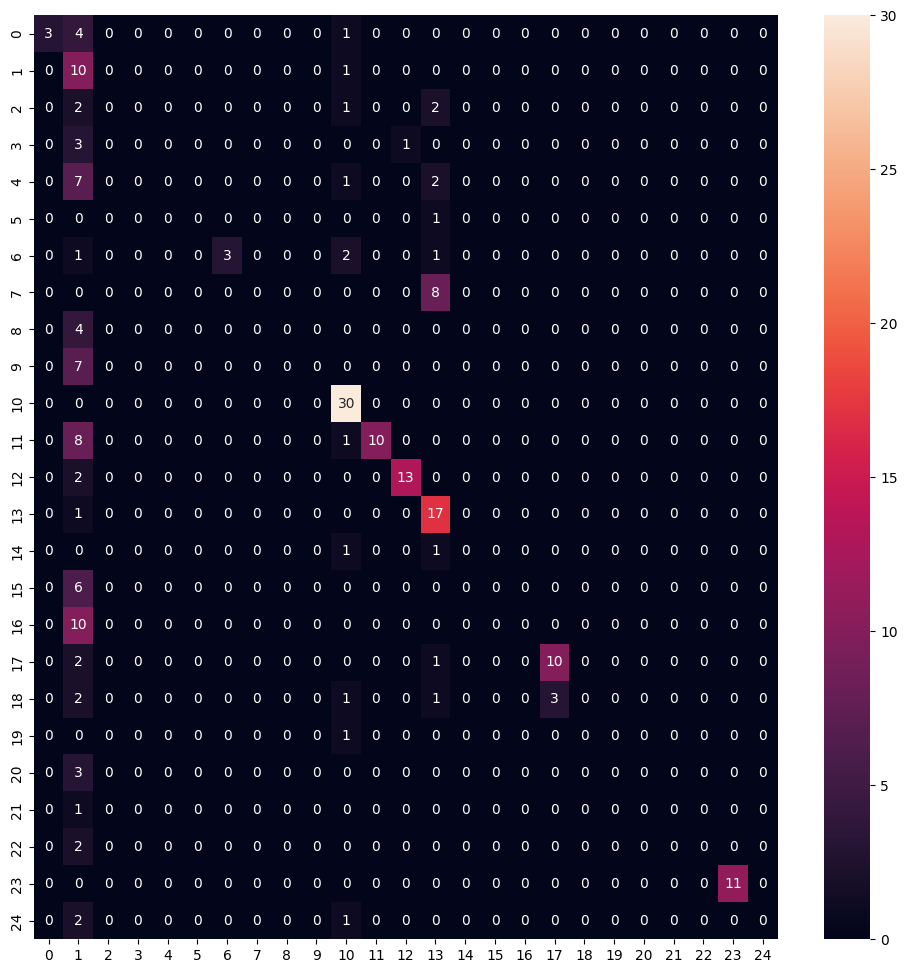


Classification Report :

               precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.13      0.91      0.23        11
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         1
           6       1.00      0.43      0.60         7
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7
          10       0.73      1.00      0.85        30
          11       1.00      0.53      0.69        19
          12       0.93      0.87      0.90        15
          13       0.50      0.94      0.65        18
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00        10


In [30]:
nb_acc = eval_sc(NB,X_train, X_test, y_train, y_test)

#### SUPPORT VECTOR MACHINE

In [31]:
SVM = make_pipeline(StandardScaler(), SVC(kernel='linear'))


Accuracy :  0.7718446601941747 %

Confusion Matrix :


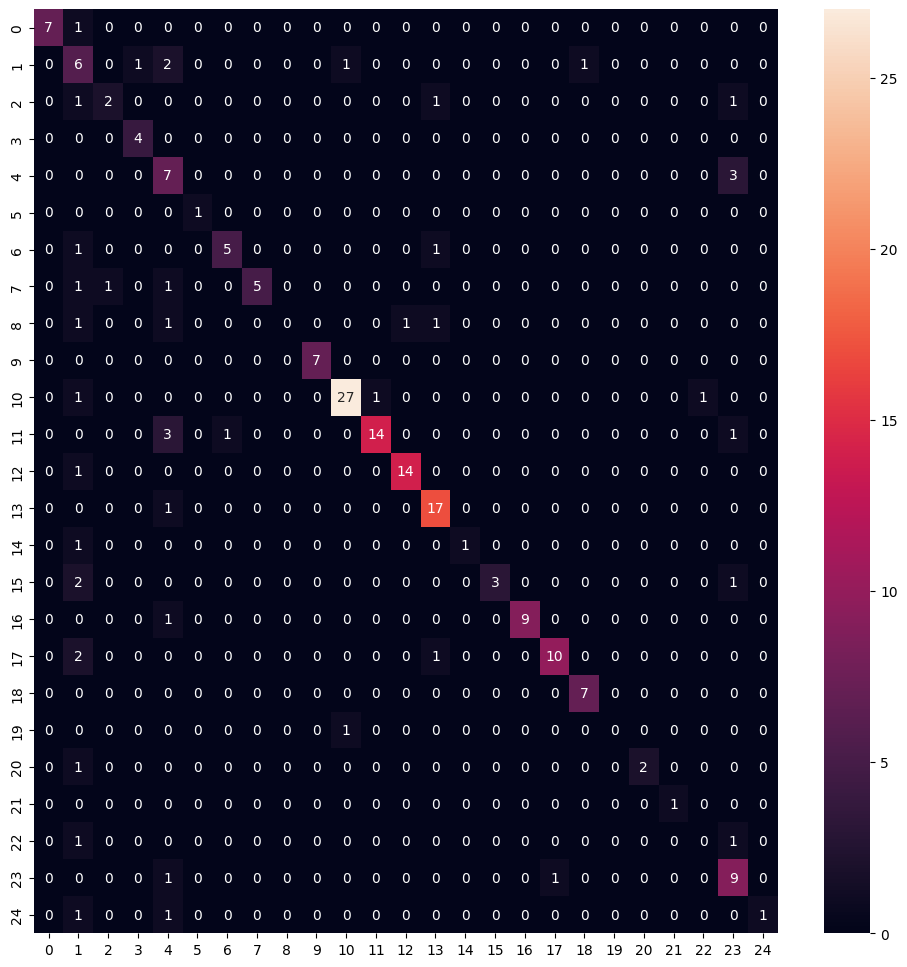


Classification Report :

               precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.29      0.55      0.37        11
           2       0.67      0.40      0.50         5
           3       0.80      1.00      0.89         4
           4       0.39      0.70      0.50        10
           5       1.00      1.00      1.00         1
           6       0.83      0.71      0.77         7
           7       1.00      0.62      0.77         8
           8       0.00      0.00      0.00         4
           9       1.00      1.00      1.00         7
          10       0.93      0.90      0.92        30
          11       0.93      0.74      0.82        19
          12       0.93      0.93      0.93        15
          13       0.81      0.94      0.87        18
          14       1.00      0.50      0.67         2
          15       1.00      0.50      0.67         6
          16       1.00      0.90      0.95        10


In [32]:
svm_acc = eval_sc(SVM, X_train, X_test, y_train, y_test)

#### RANDOM FOREST CLASSIFER

In [52]:
RF = RandomForestClassifier()


Accuracy :  0.8252427184466019 %

Confusion Matrix :


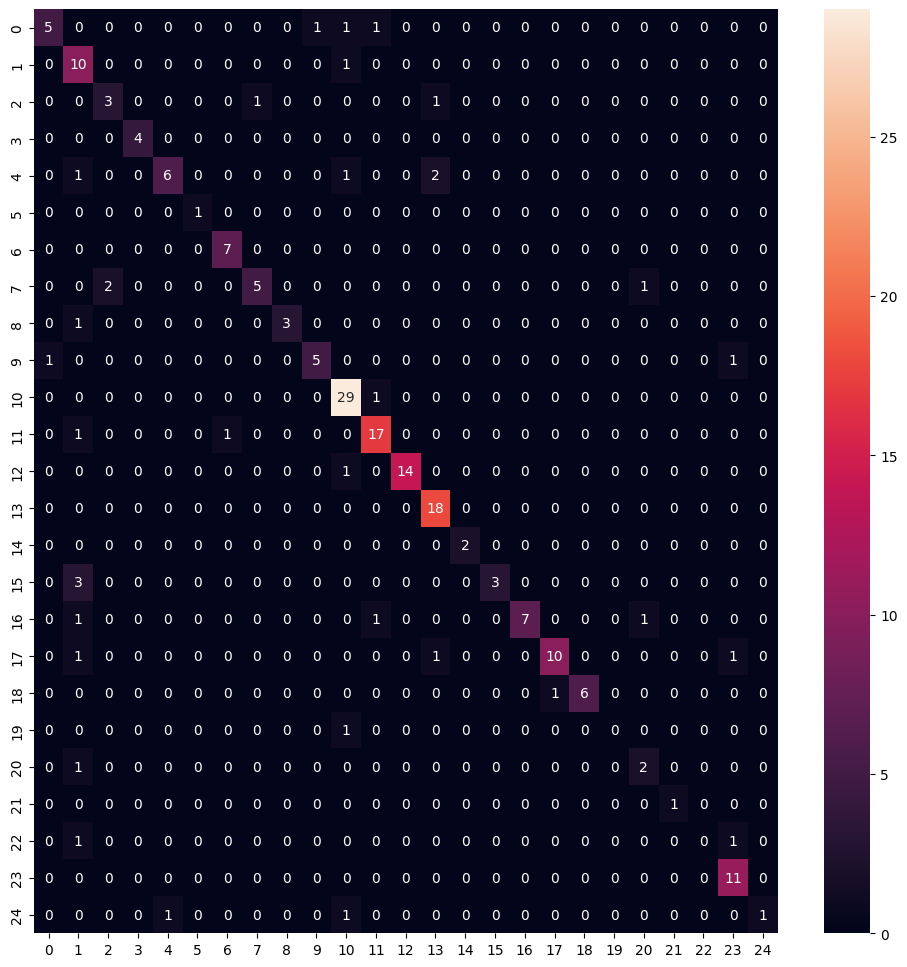


Classification Report :

               precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.50      0.91      0.65        11
           2       0.60      0.60      0.60         5
           3       1.00      1.00      1.00         4
           4       0.86      0.60      0.71        10
           5       1.00      1.00      1.00         1
           6       0.88      1.00      0.93         7
           7       0.83      0.62      0.71         8
           8       1.00      0.75      0.86         4
           9       0.83      0.71      0.77         7
          10       0.83      0.97      0.89        30
          11       0.85      0.89      0.87        19
          12       1.00      0.93      0.97        15
          13       0.82      1.00      0.90        18
          14       1.00      1.00      1.00         2
          15       1.00      0.50      0.67         6
          16       1.00      0.70      0.82        10


In [53]:
rf_acc = eval_sc(RF, X_train, X_test, y_train, y_test)

### HYPER PARAMETER TUNING

In [35]:
def grid_search(model, parameters, X_train, X_test, y_train, y_test):
    
    # Doing a grid
    grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, verbose=2, scoring='accuracy')
    
    # Fitting the grid 
    grid.fit(X_train,y_train)
    print()

    # Best model found using grid search
    optimal_model = grid.best_estimator_
    print('\nBest parameters : ', grid.best_params_)    
    print("\nBest Score", grid.best_score_)
    
    return optimal_model

#### NAIVE BAYES

In [36]:
nb_parameters ={
    "alpha":[0.1, 0.2, 0.5, 1.0, 2.0]
}

In [37]:
nb = MultinomialNB()

In [48]:
nb_optimal = grid_search(nb, nb_parameters, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ........................................


Accuracy :  0.6990291262135923 %

Confusion Matrix :


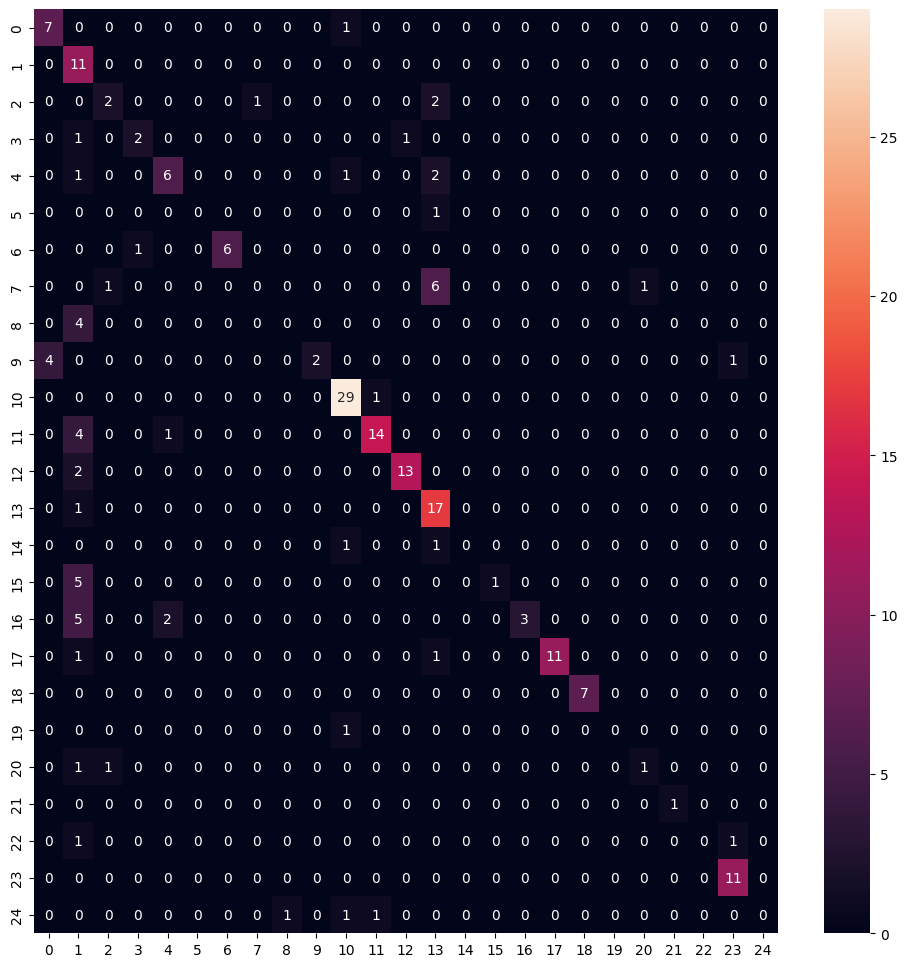


Classification Report :

               precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.30      1.00      0.46        11
           2       0.50      0.40      0.44         5
           3       0.67      0.50      0.57         4
           4       0.67      0.60      0.63        10
           5       0.00      0.00      0.00         1
           6       1.00      0.86      0.92         7
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         4
           9       1.00      0.29      0.44         7
          10       0.85      0.97      0.91        30
          11       0.88      0.74      0.80        19
          12       0.93      0.87      0.90        15
          13       0.57      0.94      0.71        18
          14       0.00      0.00      0.00         2
          15       1.00      0.17      0.29         6
          16       1.00      0.30      0.46        10


In [38]:
nb_tune = eval_sc(MultinomialNB(alpha = 0.1),X_train, X_test, y_train, y_test)

#### SUPPORT VECTOR MACHINE

In [39]:
svm_parameters ={
    "C":[0.1,1,10],
    "kernel":['linear', 'rbf', 'sigmoid'],
    "gamma":['scale', 'auto']
}

In [51]:
svm_optimal = grid_search(SVC(probability=True), svm_parameters, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  10.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  10.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  10.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  10.7s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  10.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  15.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  18.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  15.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  15.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  15.5s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=  11.2s
[CV] END .................C=0.1, gamma=scale, ke


Accuracy :  0.8300970873786407 %

Confusion Matrix :


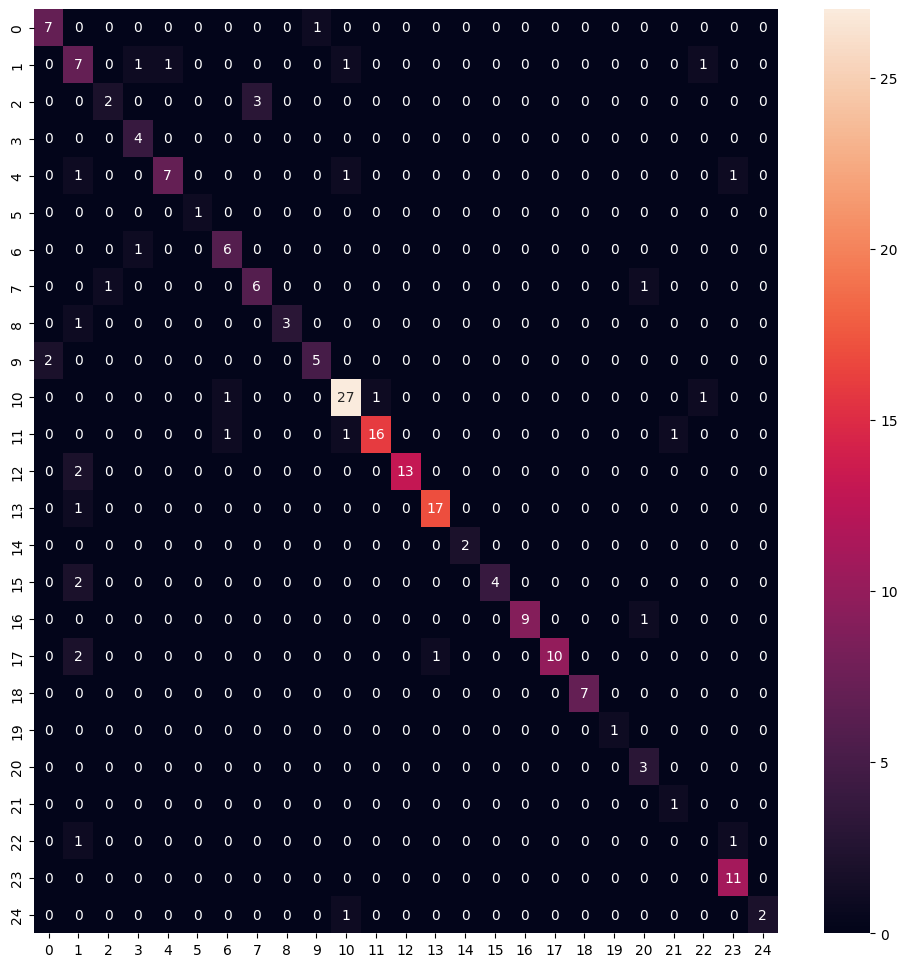


Classification Report :

               precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.41      0.64      0.50        11
           2       0.67      0.40      0.50         5
           3       0.67      1.00      0.80         4
           4       0.88      0.70      0.78        10
           5       1.00      1.00      1.00         1
           6       0.75      0.86      0.80         7
           7       0.67      0.75      0.71         8
           8       1.00      0.75      0.86         4
           9       0.83      0.71      0.77         7
          10       0.87      0.90      0.89        30
          11       0.94      0.84      0.89        19
          12       1.00      0.87      0.93        15
          13       0.94      0.94      0.94        18
          14       1.00      1.00      1.00         2
          15       1.00      0.67      0.80         6
          16       1.00      0.90      0.95        10


In [59]:
svm_tune = eval_sc(SVC(C = 10, gamma = 'scale', kernel = 'sigmoid'), X_train, X_test, y_train, y_test)

#### RANDOM FOREST CLASSIFER

In [41]:
rf_parameters = {'n_estimators': [5,20,50,100],
'max_features': ['auto', 'sqrt'],
'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
'min_samples_split': [2, 6, 10],
'min_samples_leaf': [1, 3, 4],
'bootstrap': [True, False]}

In [95]:
rf_optimal = grid_search(RandomForestClassifier(), rf_parameters, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, 

[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto,

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqr

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqr

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqr

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=aut

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=20, max_features=au

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, max_features=a

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=20, max_features=

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=20, max_features

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=20, max_feature

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=au

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, 

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=40, max_features=auto, m

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto,

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=40, max_features=aut

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqr

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqr

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqr

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, max_features=au

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=50, max_features=a

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, max_features=

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=50, max_features

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=50, max_feature

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_feature

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_feature

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=60, max_features=

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=s

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=60, max_features=s

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=60, max_features=

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_feature

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=70, max_featu

[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=70, max_featu

[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.4s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.4s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.4s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=70, max_featu

[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=70, max_featu

[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=70, max_feat

[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=80, max_fea

[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=80, max_fe

[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_f

[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=80, max_

[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=80, max_fe

[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_feat

[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_feature

[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=a

[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, 

[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_featur

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_feat

[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_feat

[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_feat

[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_feat

[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=100, max_fea

[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=110, max_fe

[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=110, max_f

[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=110, max_

[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=110, max

[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=110, max_

[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_f

[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_fea

[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_featu

[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_feature

[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=120, max_features

[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=120, max_features

[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=True, max_depth=120, max_featur

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_feat

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_feat

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_feat

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_feat

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_fea

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_fe

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   1.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   2.1s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, max_f

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.8s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_

[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.4s
[CV] END bootstrap=False, max_depth=20, max

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   2.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   1.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   2.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max

[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   2.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   2.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   2.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   2.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   2.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_f

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_fe

[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_fe

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_fe

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_f

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   1.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=40, m

[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.1s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.1s
[CV] END bootstrap=False, max_depth=40, m

[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.4s
[CV] END bootstrap=False, max_depth=40, m

[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=40, m

[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.6s
[CV] END bootstrap=False, max_depth=40, 

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.9s
[CV] END bootstrap=False, max_depth=50,

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=50

[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   1.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.4s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=5

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.4s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   1.4s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.9s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   1.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   3.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   3.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   3.5s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   3.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   3.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=50

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.5s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.3s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.2s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.2s
[CV] END bootstrap=False, max_depth=60, 

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   2.4s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   2.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_fe

[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.2s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.3s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.2s
[CV] END bootstrap=False, max_depth=60, max_featu

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   2.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_feature

[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=60, max_features

[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=70, max_feature

[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=70, max_featur

[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=70, max_feat

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=False, max_depth=70, max_feat

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_feat

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=70, max_feat

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=False, max_depth=80, max_fea

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=False, max_depth=80, max_fe

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_f

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=80, max_

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=False, max_depth=80, max

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=80, max_

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_f

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_fea

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_featu

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_feature

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=90, max_features

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, max

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, ma

[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, m

[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   1.4s
[CV] END bootstrap=False, max_depth=100, m

[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=100, 

[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=100, 

[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   1.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   1.5s
[CV] END bootstrap=False, max_depth=110, 

[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=110, 

[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   1.2s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=110, 

[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.6s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   1.5s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   1.6s
[CV] END bootstrap=False, max_depth=110, 

[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   1.0s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   1.1s
[CV] END bootstrap=False, max_depth=110, 

[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=110, 

[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.5s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   1.1s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   1.1s
[CV] END bootstrap=False, max_depth=120, 

[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   1.0s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   1.1s
[CV] END bootstrap=False, max_depth=120, 

[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=120, 

[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   1.3s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   1.0s
[CV] END bootstrap=False, max_depth=120, 

[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   1.0s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   1.0s
[CV] END bootstrap=False, max_depth=120, 

[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.4s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.3s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.9s
[CV] END bootstrap=False, max_depth=120, 


Accuracy :  0.8349514563106796 %

Confusion Matrix :


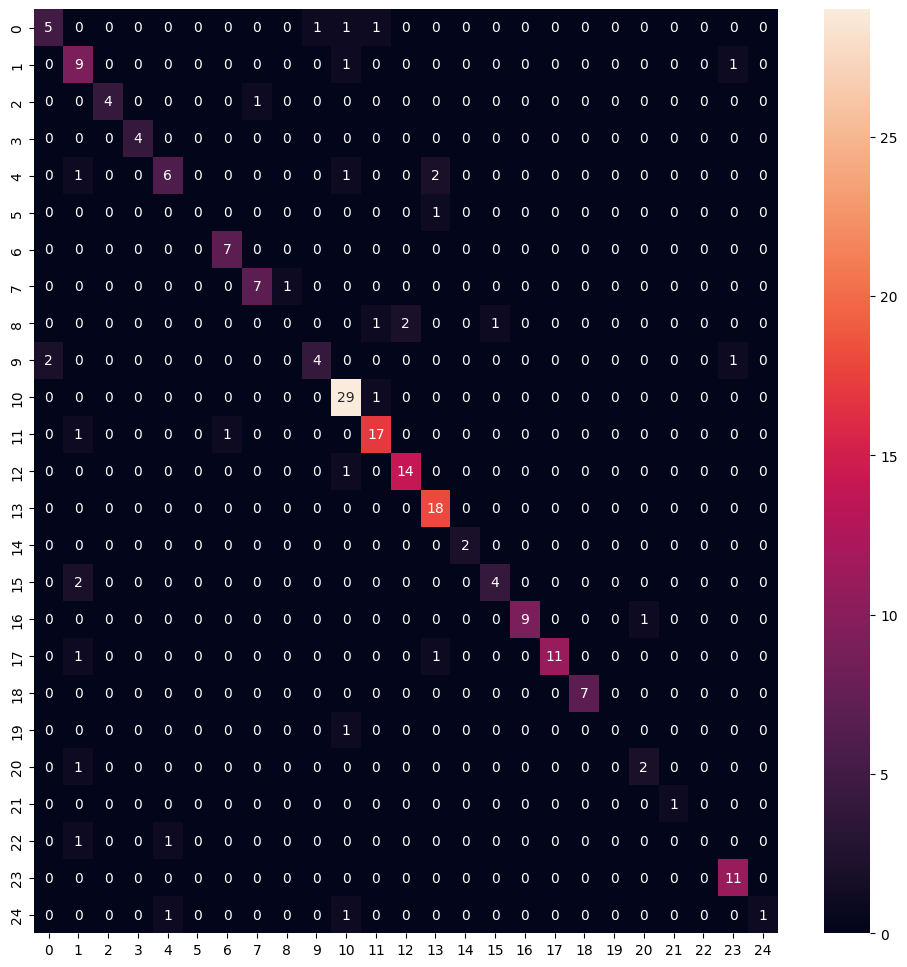


Classification Report :

               precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.56      0.82      0.67        11
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         4
           4       0.75      0.60      0.67        10
           5       0.00      0.00      0.00         1
           6       0.88      1.00      0.93         7
           7       0.88      0.88      0.88         8
           8       0.00      0.00      0.00         4
           9       0.80      0.57      0.67         7
          10       0.83      0.97      0.89        30
          11       0.85      0.89      0.87        19
          12       0.88      0.93      0.90        15
          13       0.82      1.00      0.90        18
          14       1.00      1.00      1.00         2
          15       0.80      0.67      0.73         6
          16       1.00      0.90      0.95        10


In [62]:
rf_tune = eval_sc(RandomForestClassifier(bootstrap = False, max_depth = 110, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100), X_train, X_test, y_train, y_test)

#### BEFORE TUNING MODEL

In [63]:
before_sc = pd.DataFrame({'Model':['NB','SVM','RF'],
                    'Accuracy Score':[nb_acc, svm_acc, rf_acc]
                         })
before_sc

,Model,Accuracy Score
0,NB,0.519417
1,SVM,0.771845
2,RF,0.825243


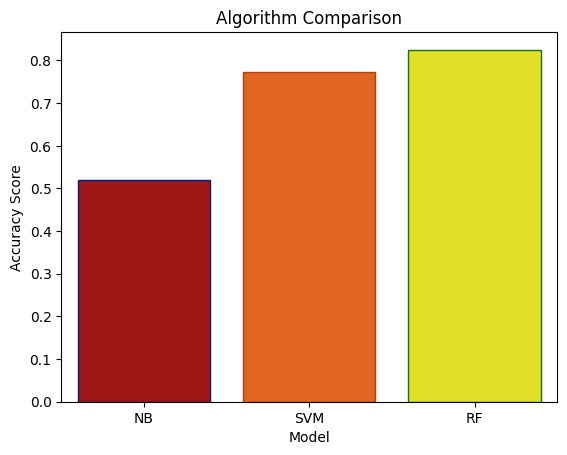

In [64]:
# Barplot algorithm comparison

sns.barplot(x = "Model", y = "Accuracy Score", data = before_sc, palette='hot', edgecolor = sns.color_palette('dark',7))
plt.title('Algorithm Comparison')
plt.show()

#### AFTER TUNING MODEL

In [65]:
after_sc = pd.DataFrame({'Model':['NB','SVM','RF'],                         
                    'Accuracy Score':[nb_tune, svm_tune, rf_tune]
                        })
after_sc

,Model,Accuracy Score
0,NB,0.699029
1,SVM,0.830097
2,RF,0.834951


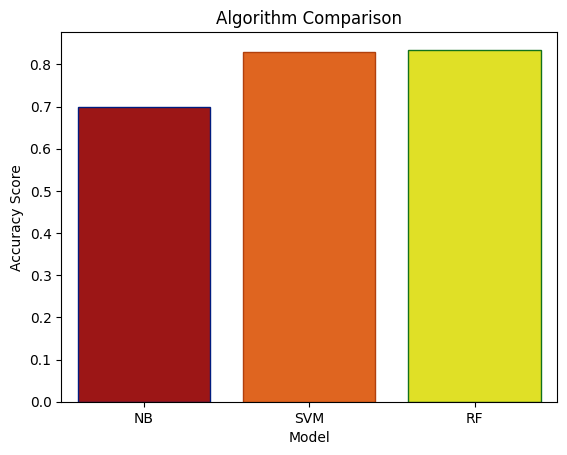

In [66]:
# Barplot algorithm comparison

sns.barplot(x = "Model", y = "Accuracy Score", data = after_sc, palette='hot', edgecolor = sns.color_palette('dark',7))
plt.title('Algorithm Comparison')
plt.show()

#### COMPARISON PLOT 

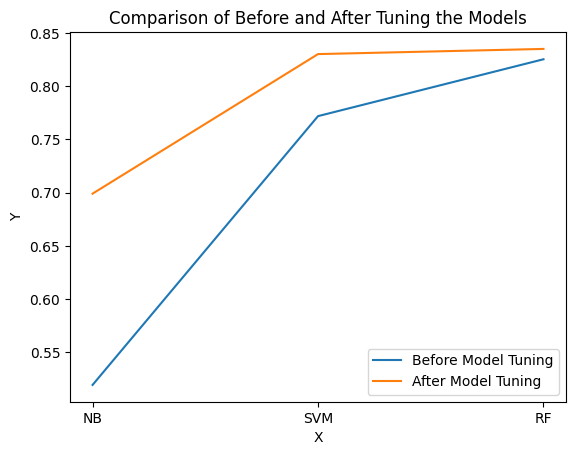

In [67]:
x = after_sc['Model']
y_before = before_sc['Accuracy Score']
y_after = after_sc['Accuracy Score']

plt.plot(x, y_before, label='Before Model Tuning')
plt.plot(x, y_after, label='After Model Tuning')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Comparison of Before and After Tuning the Models')
plt.legend()

plt.show()

#### BEST MODEL EVALUATED

In [68]:
# Model Selected
select_model = RandomForestClassifier(bootstrap = False, max_depth = 110, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100)

# Model Fitting
select_model = select_model.fit(X_train, y_train)


In [69]:
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(select_model, file)

### PREDICTION FOR THE DATASET

In [70]:
t_data = pd.DataFrame.from_dict(df['processed_data'])

In [71]:
t_data['label'] = df['industry']
t_data['actual'] = df['target']

In [74]:
test = vectorizer.transform(t_data.processed_data).toarray()
pred = select_model.predict(test)

In [75]:
pred = np.argmax(pred)
y_pred = (pred > 0.5) 
t_data['predicted'] = y_pred

In [76]:
t_data.sample(10)

,processed_data,label,actual,predicted
397,engineering solution architect looking solutio...,Engineering,7,True
365,educator education teacher looking committed t...,Educator & Education,6,True
225,development system analyst looking system anal...,IT and Development,13,True
534,healthcare child psychologist job description ...,Healthcare,10,True
392,engineering engineering manager looking engine...,Engineering,7,True
757,law enforcement security deputy sheriff lookin...,Law enforcement / Security,14,True
354,educator education librarian looking experienc...,Educator & Education,6,True
1007,sales insurance agent looking competitive insu...,Sales,24,True
790,legal legal assistant looking self motivated l...,Legal,15,True
493,healthcare gastroenterology looking gastroente...,Healthcare,10,True
